In [17]:
# import external modules
import sys, os
ROOT_PATH = os.path.abspath(".").split("src")[0]
module_path = os.path.abspath(os.path.join(ROOT_PATH+"/src/utils/"))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import warnings
from copy import deepcopy
warnings.filterwarnings("ignore")

import functions as f

SEED=100; np.random.seed(100)

In [3]:
# load scaled datasets 
path = ROOT_PATH + "data/dataframes/"
df_complete = pd.read_pickle(path + "df_scaled_complete.pkl")

TRAIN_PERCENTAGE = 0.6         
VALID_PERCENTAGE = 0.2         
TEST_PERCENTAGE = 1.0 - TRAIN_PERCENTAGE - VALID_PERCENTAGE

train_size = int(TRAIN_PERCENTAGE * len(df_complete))
valid_size = int(VALID_PERCENTAGE * len(df_complete))
test_size = len(df_complete) - train_size - valid_size

df_train = df_complete[0:train_size] 
df_valid = df_complete[train_size:train_size+valid_size] 
df_test = df_complete[-test_size:]

In [4]:
# split X and Y. We are using a lookback value for -1 
# Meaning for every input instrument at time T, we are predicting the value of the output instrument at time T+1 minute
def splitXY(dataset,target_columns,lookbackValue=1): 
    assert len(target_columns) > 0, "Please ensure target_columns value are not empty."
    assert lookbackValue > 0, "Please ensure lookbackValue > 0."

    target_columns_lookback = [target+"_lookback" for target in target_columns]
    dataset[target_columns_lookback] = None
    for i in range(len(target_columns_lookback)): 
        dataset[target_columns_lookback[i]][0:-lookbackValue] = dataset[target_columns[i]][lookbackValue:]
    dataset = dataset[0:-lookbackValue].reset_index()
    
    dataset.drop(dataset[target_columns],axis=1,inplace = True)
    renameDict = {} 
    for i in range(len(target_columns)): 
        renameDict[target_columns_lookback[i]] = target_columns[i]
    dataset.rename(columns = renameDict, inplace = True)
    
    x_train = dataset.drop(dataset[target_columns],axis=1)
    x_train.drop(x_train[["timestamp"]],axis=1,inplace=True)

    y_train = dataset[target_columns]
    return x_train,y_train

targetCols = ["VAL_23-FT-92537-01:X.Value","VAL_23-TT-92539:X.Value","VAL_23-PT-92539:X.Value"]
x_train,y_train = splitXY(df_train,targetCols,lookbackValue=1)
x_valid,y_valid = splitXY(df_valid,targetCols,lookbackValue=1)
x_test,y_test = splitXY(df_valid,targetCols,lookbackValue=1)

In [5]:
# load metadata (done by the original author)
path = ROOT_PATH + "data/metadata/"
scaling_stats = pd.read_csv(path+"scaling_stats.csv", index_col=0)
target_tags = y_train.columns
feature_tags = x_train.columns
target_stds = scaling_stats.loc[target_tags,"Std"].values
target_means = scaling_stats.loc[target_tags,"Mean"].values
print(df_train.shape, df_valid.shape, df_test.shape)

(53211, 24) (17737, 24) (17737, 21)


In [6]:
# the tagnames for these instruments are too long. We are shortening them with this function
def shorten_tagname(tag):
    nname = tag.split("VAL_23")[1][1:]
    nname = nname.split(".Value")[0]
    nname = nname.split(":VALUE")[0]
    nname = nname.split(":X")[0]
    
    if "KA_9101" in nname:
        nname = nname.split(":Z.X")[0]
    return nname

short_feature_tags = np.array([shorten_tagname(tag) for tag in feature_tags])
featureTagsShotenDict = {}
for i in range(len(feature_tags)): 
    featureTagsShotenDict[feature_tags[i]] = short_feature_tags[i]

Text(0.5, 1.0, 'Correlation Matrix Plot')

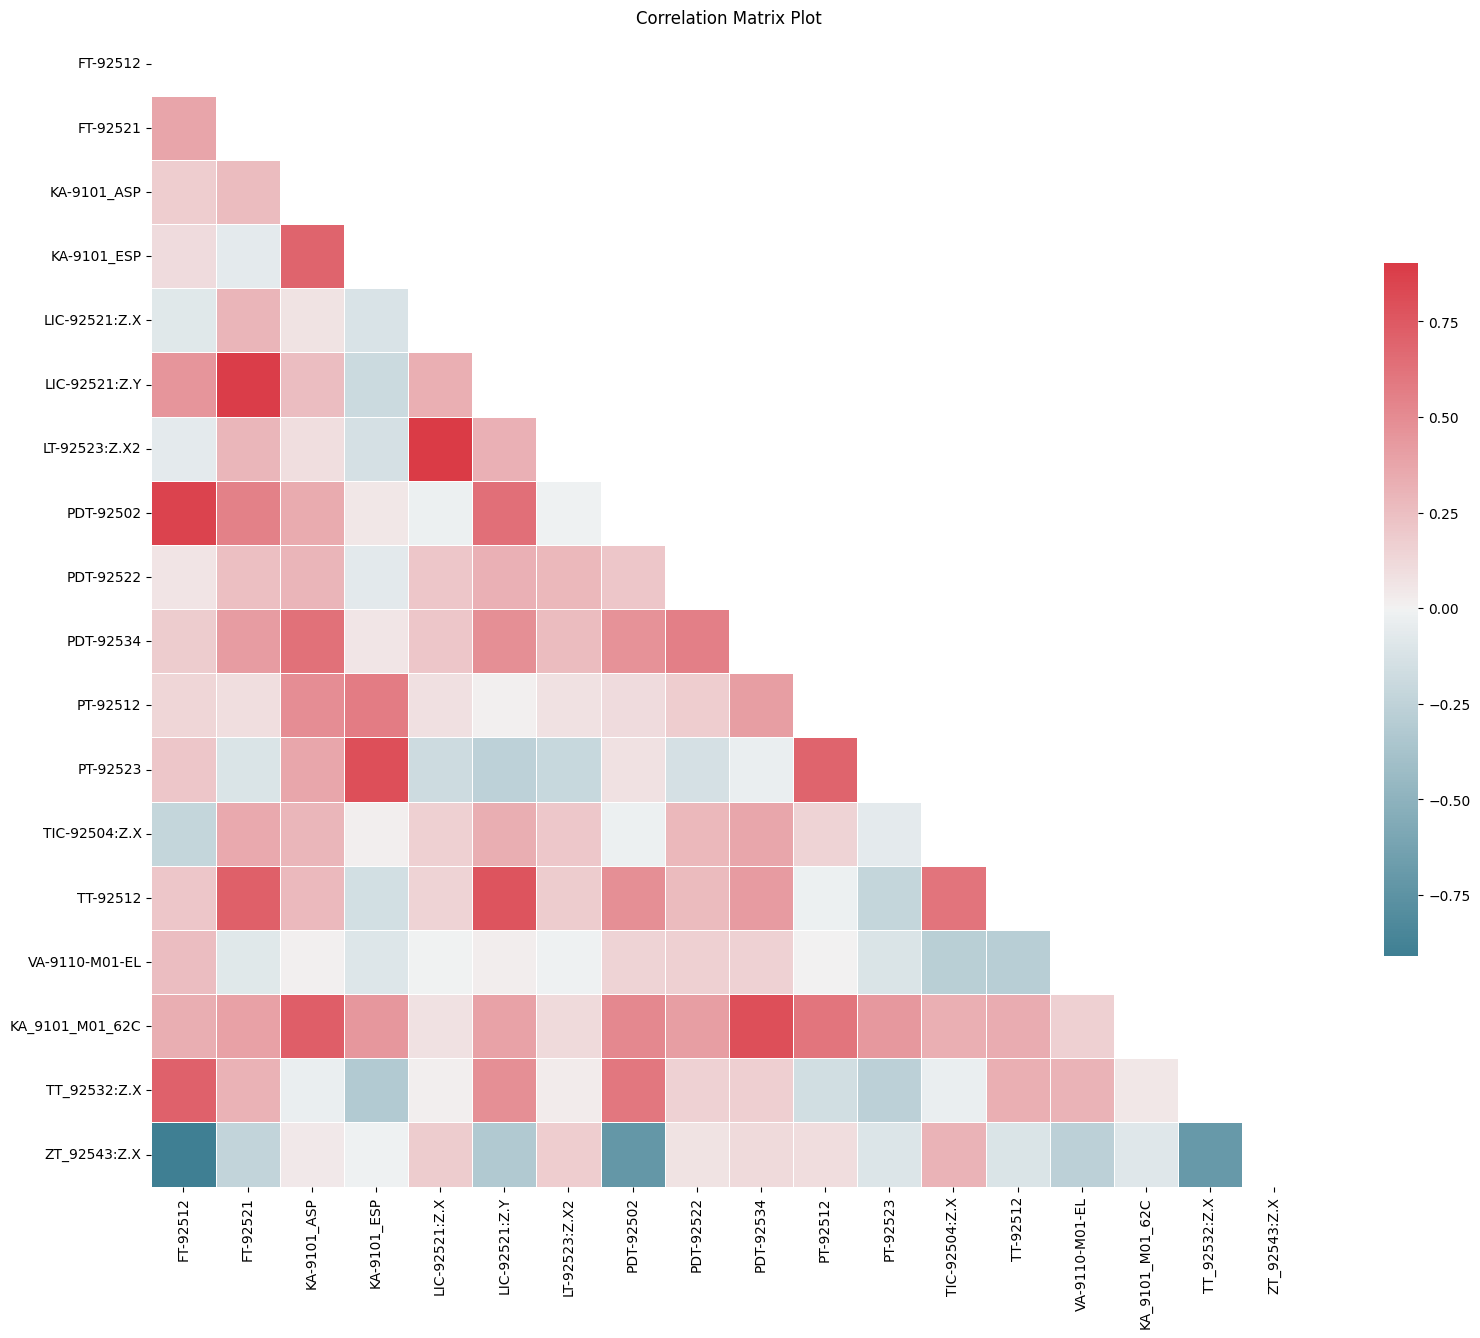

In [55]:
# Obtain training data correlation matrix: 
corrMat = x_train.corr()
tempColName = [shorten_tagname(col) for col in x_train.columns]
corrMat.index =tempColName
corrMat.columns=tempColName

mask = np.zeros_like(corrMat,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig,axis = plt.subplots(figsize=(20,15))

colorMap = sns.diverging_palette(220,10,as_cmap=True)

sns.heatmap(corrMat,mask = mask,cmap=colorMap,square = True,linewidths = 0.5,cbar_kws={"shrink": .6})
axis.set_title("Correlation Matrix Plot")

In [34]:
# Obtain training data correlation matrix: 
corrMat = x_train.corr()
# Ensure that the correlation values are all positive. We just want significance not the direction
feat_thresh = 0.85
corrMat = np.abs(corrMat)
corrMatCorrected = deepcopy(corrMat)
for index,row in corrMat.iterrows():
    for col in corrMat.columns:
        if index != col and (corrMat[index][col] > feat_thresh):
            corrMatCorrected[index][col] = None
corrMatCorrected = corrMatCorrected.dropna(axis=1)
corr_remainingFeatures = [shorten_tagname(name) for name in corrMatCorrected.columns]

In [6]:
# The feature correlation algorithms 
# Could use boruta 
# Could also use pearson? 
# Kendall’s Rank Correlation
# Pearson’s Correlation Coefficient
# Spearman’s Rank Correlation

In [7]:
# Performing feature importance calculation using linear correlation testing. 
# Reference: https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/

from scipy.stats import spearmanr, pearsonr, kendalltau
def calculateCorrelation(corrFunction,xValues,yValues,corrName): 
    xCols = list(xValues.columns)
    yCols = list(yValues.columns)
    corrDataFrame = {}
    for col in yCols: 
        corrDataFrame[col] = None
    
    for ycol in yCols: 
        outputDict = {
        "featureColumn": [],
        "targetColumn":[],
        "score":[],
        "pVal": [],
        "correlationAlgo": []
    }
        yVals = yValues[ycol]
        for xcol in xCols:
            xVals = xValues[xcol]
            stat, p = corrFunction(xVals,yVals)
            outputDict["featureColumn"].append(shorten_tagname(xcol))
            outputDict["targetColumn"].append(ycol)
            outputDict["score"].append(stat)
            outputDict["pVal"].append(p)
            outputDict["correlationAlgo"].append(corrName)
        outputDataFrame = pd.DataFrame(outputDict)
        outputDataFrame["score"] = outputDataFrame["score"].abs()
        outputDataFrame = outputDataFrame.loc[abs(outputDataFrame.pVal) < 0.05]
        outputDataFrame.sort_values("score", axis=0, ascending=False,inplace=True)
        corrDataFrame[ycol] = outputDataFrame

    return corrDataFrame

spearmanCorr = calculateCorrelation(spearmanr,x_train,y_train,"spearmanr")
pearsonCorr = calculateCorrelation(pearsonr,x_train,y_train,"pearson")
kendallCorr = calculateCorrelation(kendalltau,x_train,y_train,"kendall")

In [8]:
ycols = list(y_train.columns)
spearman_FT_92537 = spearmanCorr[ycols[0]][:10]
pearson_FT_92537  = pearsonCorr[ycols[0]][:10]
kendall_FT_92537  = kendallCorr[ycols[0]][:10]

spearman_TT_92539 = spearmanCorr[ycols[1]][:10]
pearson_TT_92539  = pearsonCorr[ycols[1]][:10]
kendall_TT_92539  = kendallCorr[ycols[1]][:10]

spearman_PT_92539 = spearmanCorr[ycols[2]][:10]
pearson_PT_92539  = pearsonCorr[ycols[2]][:10]
kendall_PT_92539  = kendallCorr[ycols[2]][:10]


In [9]:
spearman_FT_92537_names = list(spearmanCorr[ycols[0]][:10]["featureColumn"])
pearson_FT_92537_names  = list(pearsonCorr[ycols[0]][:10]["featureColumn"])
kendall_FT_92537_names  = list(kendallCorr[ycols[0]][:10]["featureColumn"])

spearman_TT_92539_names = list(spearmanCorr[ycols[1]][:10]["featureColumn"])
pearson_TT_92539_names  = list(pearsonCorr[ycols[1]][:10]["featureColumn"])
kendall_TT_92539_names  = list(kendallCorr[ycols[1]][:10]["featureColumn"])

spearman_PT_92539_names = list(spearmanCorr[ycols[2]][:10]["featureColumn"])
pearson_PT_92539_names  = list(pearsonCorr[ycols[2]][:10]["featureColumn"])
kendall_PT_92539_names  = list(kendallCorr[ycols[2]][:10]["featureColumn"])

In [10]:
# Checking whcih features are most important for FT output
commonTags_FT_92537 = []
for tag in spearman_FT_92537_names: 
    if tag in pearson_FT_92537_names and tag in kendall_FT_92537_names:
        commonTags_FT_92537.append(tag)
commonTags_FT_92537

['PDT-92534',
 'KA_9101_M01_62C',
 'KA-9101_ASP',
 'FT-92521',
 'LIC-92521:Z.Y',
 'PDT-92522',
 'TIC-92504:Z.X',
 'TT-92512',
 'PT-92512',
 'ZT_92543:Z.X']

In [11]:
# Checking whcih features are most important for TT output
commonTags_TT_92539 = []
for tag in spearman_TT_92539_names: 
    if tag in pearson_TT_92539_names and tag in kendall_TT_92539_names:
        commonTags_TT_92539.append(tag)
commonTags_TT_92539

['TT_92532:Z.X',
 'ZT_92543:Z.X',
 'FT-92512',
 'PDT-92502',
 'LIC-92521:Z.Y',
 'TT-92512',
 'FT-92521',
 'PT-92512',
 'KA-9101_ESP',
 'VA-9110-M01-EL']

In [12]:
# Checking whcih features are most important for PT output 
commonTags_PT_92539 = []
for tag in spearman_PT_92539_names: 
    if tag in pearson_PT_92539_names and tag in kendall_PT_92539_names:
        commonTags_PT_92539.append(tag)
commonTags_PT_92539

['PT-92523',
 'KA-9101_ESP',
 'PT-92512',
 'KA_9101_M01_62C',
 'KA-9101_ASP',
 'TT_92532:Z.X',
 'FT-92512',
 'TIC-92504:Z.X',
 'FT-92521',
 'LIC-92521:Z.X']

In [13]:
spearmanFT = spearmanCorr[ycols[0]][["featureColumn","score"]] 
spearmanTT = spearmanCorr[ycols[1]][["featureColumn","score"]]
spearmanPT = spearmanCorr[ycols[2]][["featureColumn","score"]]

merged3_spearman = spearmanFT.merge(spearmanTT, on='featureColumn', how='left')
merged3_spearman = merged3_spearman.merge(spearmanPT, on='featureColumn', how='left')
merged3_spearman.columns = ["featureColumn","FT","TT","PT"]
merged3_spearman.dropna(axis = 0,inplace = True)
merged3_spearman["averageSpearman"] = (merged3_spearman["FT"]+merged3_spearman["TT"]+merged3_spearman["PT"]) / 3 
merged3_spearman.sort_values("averageSpearman",ascending=False,inplace = True)
merged3_spearman = merged3_spearman[:10]
merged3_spearman

,featureColumn,FT,TT,PT,averageSpearman
8,PT-92512,0.205671,0.234454,0.610229,0.350118
17,TT_92532:Z.X,0.029532,0.819830,0.197172,0.348845
9,ZT_92543:Z.X,0.167392,0.728701,0.078159,0.324750
16,KA-9101_ESP,0.032373,0.202044,0.669116,0.301178
1,KA_9101_M01_62C,0.380740,0.052007,0.464555,0.299101
13,PT-92523,0.076321,0.091579,0.689879,0.285926
15,FT-92512,0.036031,0.634652,0.127643,0.266109
3,FT-92521,0.319052,0.285168,0.094367,0.232862
2,KA-9101_ASP,0.335724,0.019193,0.323428,0.226115
14,PDT-92502,0.066853,0.537335,0.059896,0.221362


In [14]:
pearsonFT = pearsonCorr[ycols[0]][["featureColumn","score"]] 
pearsonTT = pearsonCorr[ycols[1]][["featureColumn","score"]]
pearsonPT = pearsonCorr[ycols[2]][["featureColumn","score"]]

merged3_pearson = pearsonFT.merge(pearsonTT, on='featureColumn', how='left')
merged3_pearson = merged3_pearson.merge(pearsonPT, on='featureColumn', how='left')
merged3_pearson.columns = ["featureColumn","FT","TT","PT"]
merged3_pearson.dropna(axis = 0,inplace = True)
merged3_pearson["averagePearson"] = (merged3_pearson["FT"]+merged3_pearson["TT"]+merged3_pearson["PT"]) / 3 
merged3_pearson.sort_values("averagePearson",ascending=False,inplace = True)
merged3_pearson = merged3_pearson[:10]

In [15]:
kendallFT = kendallCorr[ycols[0]][["featureColumn","score"]] 
kendallTT = kendallCorr[ycols[1]][["featureColumn","score"]]
kendallPT = kendallCorr[ycols[2]][["featureColumn","score"]]

merged3_kendall = kendallFT.merge(kendallTT, on='featureColumn', how='left')
merged3_kendall = merged3_kendall.merge(kendallPT, on='featureColumn', how='left')
merged3_kendall.columns = ["featureColumn","FT","TT","PT"]
merged3_kendall.dropna(axis = 0,inplace = True)
merged3_kendall["averageKendall"] = (merged3_kendall["FT"]+merged3_kendall["TT"]+merged3_kendall["PT"]) / 3 
merged3_kendall.sort_values("averageKendall",ascending=False,inplace = True)
merged3_kendall = merged3_kendall[:10]

In [19]:
merged3_spearman_names = list(merged3_spearman.featureColumn)
merged3_pearson_names = list(merged3_pearson.featureColumn)
merged3_kendall_names = list(merged3_kendall.featureColumn)
intersectAverage = []
for tag in merged3_spearman_names: 
    if tag in merged3_pearson_names and tag in merged3_kendall_names: 
        intersectAverage.append(tag)

intersectFinal = []
for tag in intersectAverage:
    if tag in commonTags_FT_92537 or tag in commonTags_TT_92539 or tag in commonTags_PT_92539:
        intersectFinal.append(tag)
intersectFinal

['PT-92512',
 'ZT_92543:Z.X',
 'KA-9101_ESP',
 'PT-92523',
 'FT-92512',
 'FT-92521',
 'KA-9101_ASP',
 'PDT-92502']

In [21]:
merged3_spearman.sort_values("averageSpearman",ascending=False)

,featureColumn,FT,TT,PT,averageSpearman
8,PT-92512,0.205671,0.234454,0.610229,0.350118
17,TT_92532:Z.X,0.029532,0.819830,0.197172,0.348845
9,ZT_92543:Z.X,0.167392,0.728701,0.078159,0.324750
16,KA-9101_ESP,0.032373,0.202044,0.669116,0.301178
1,KA_9101_M01_62C,0.380740,0.052007,0.464555,0.299101
13,PT-92523,0.076321,0.091579,0.689879,0.285926
15,FT-92512,0.036031,0.634652,0.127643,0.266109
3,FT-92521,0.319052,0.285168,0.094367,0.232862
2,KA-9101_ASP,0.335724,0.019193,0.323428,0.226115
14,PDT-92502,0.066853,0.537335,0.059896,0.221362


In [23]:
merged3_pearson.sort_values("averagePearson",ascending=False)

,featureColumn,FT,TT,PT,averagePearson
9,PT-92512,0.204568,0.238850,0.621116,0.354845
8,ZT_92543:Z.X,0.218124,0.775352,0.067461,0.353646
13,FT-92512,0.109280,0.704706,0.115285,0.309757
14,PT-92523,0.053352,0.096899,0.688745,0.279665
16,KA-9101_ESP,0.032836,0.188588,0.577158,0.266194
15,PDT-92502,0.035344,0.596387,0.049632,0.227121
6,FT-92521,0.255139,0.297949,0.104770,0.219286
7,TT-92512,0.249594,0.390860,0.016871,0.219108
2,KA-9101_ASP,0.302618,0.049847,0.297398,0.216621
0,PDT-92534,0.452858,0.081294,0.046003,0.193385


In [24]:
merged3_kendall.sort_values("averageKendall",ascending=False)

,featureColumn,FT,TT,PT,averageKendall
17,TT_92532:Z.X,0.019773,0.629924,0.131950,0.260549
8,PT-92512,0.139885,0.157851,0.433700,0.243812
9,ZT_92543:Z.X,0.112151,0.542452,0.051717,0.235440
16,KA-9101_ESP,0.022547,0.135339,0.481716,0.213201
1,KA_9101_M01_62C,0.261937,0.035338,0.320158,0.205811
13,PT-92523,0.050694,0.061846,0.499748,0.204096
15,FT-92512,0.023350,0.457334,0.085000,0.188561
3,FT-92521,0.218056,0.194719,0.062912,0.158562
14,PDT-92502,0.045404,0.377351,0.039860,0.154205
2,KA-9101_ASP,0.229543,0.012323,0.220372,0.154079


In [ ]:
# 

In [17]:
x_shortNames = []
for xName in x_train.columns:
    x_shortNames.append(shorten_tagname(xName))
assert len(x_shortNames) == len(x_train.columns)
x_train.columns = x_shortNames
x_valid.columns = x_shortNames
x_test.columns = x_shortNames

In [18]:
y_shortNames = []
for yName in y_train.columns:
    y_shortNames.append(shorten_tagname(yName))
assert len(y_shortNames) == len(y_train.columns)

y_train.columns = y_shortNames
y_valid.columns = y_shortNames
y_test.columns = y_shortNames

In [21]:
baseSavePath = "../data/featureEngineeredData/"

x_train.to_csv(baseSavePath+"x_train.csv",index = False)
x_valid.to_csv(baseSavePath+"x_valid.csv",index = False)
x_test.to_csv(baseSavePath+"x_test.csv",index = False)

y_train.to_csv(baseSavePath+"y_train.csv",index = False)
y_valid.to_csv(baseSavePath+"y_valid.csv",index = False)
y_test.to_csv(baseSavePath+"y_test.csv",index = False)